In [3252]:
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
import math
from math import pi
import itertools
import CUDAPython as CP
%matplotlib inline

In [3253]:
#sets number of levels (k) and number of fermions (m)
k = 10
m = 5

'''DEFINING FUNCTIONS BELOW'''

In [3254]:
def generate_energies(k):
    '''generates ordered array of k distinct energy levels'''
    energies = np.empty(k)
    count=0
    while(count!=k):
        energies[count]=normal(0,1) #samples a normal distribution k times
        count+=1
    return np.sort(energies) #output is a scaled, sorted array of size k

def size(k, m):
    '''determines the number of combination of m fermions on k energy levels'''
    return int(math.factorial(k)/((math.factorial(k-m))*(math.factorial(m))))

def ground_state(k, m):
    '''initialises a ground state based on number of fermions (m) and number of energy levels (k)
    
    e.g. for k=10, m=5:
    ground state is [1,1,1,1,1,0,0,0,0,0]'''
    state = np.zeros(k, dtype=int)
    for i in range(m):
        state[i] = 1
    return state

def permutations(state):
    '''returns a list of possible permutations of a given binary state'''
    return list(set(itertools.permutations(state)))   

def time_step(init_state, sigma_w):
    '''Determines the time step to compute the time evolution using the Fermi Golden Rule'''
    dt = 0
    if init_state==0:
        dE = D[init_state+1][init_state+1] - D[init_state][init_state]
    else:
        dE = D[init_state][init_state] - D[init_state-1][init_state-1]
    
    f = 2*pi*sigma_w**2*(1/dE) #fermi golden rule (approximation)
    
    return 1/(f*10)

#need time evolution of the D matrix
def D_evo(dt):
    '''Function that produces the D matrix for a given time t (time evolution of D matrix)'''
    D_ev = np.zeros((size(k,m), size(k,m)), dtype=complex)
    
    for x in range(size(k,m)):
        D_ev[x][x] = np.exp(-1j*D[x][x]*dt) #calculates time evolution of the diagonal elements, removed factor of 1/hbar
    return D_ev

def V_t(dt):
    '''Evolution operator at time interval dt'''
    D_exp = D_evo(dt) #evolution matrix for a time t
    left_mat = np.matmul(P, D_exp) #multiplying P*e^D
    return np.matmul(left_mat, P_T) #multiplying above by P_T

In [3255]:
def next_state(V_t, state):
    return np.matmul(V_t, state)

In [3256]:
def coefs(state):
    state_conj = np.conj(state)
    coefficients = np.empty(size(k,m))
    
    for i in range(size(k,m)):
        coefficients[i] = (np.dot(state[i], state_conj[i])).real
    return coefficients

In [3257]:
def occupation_number(state, lev):
    _sum=0
    coef = coefs(state)
    
    for i in range(size(k,m)):
        _sum += coef[i]*i_state_map[i][lev]
    return _sum

In [3258]:
def plot_init_state(energies, state):
    '''Function that displays a plot of a given state'''
    fig, axes = plt.subplots(figsize=((5,12)))
    
    axes.hlines(energies,0,1,'r', zorder=1, label='Energy level')
    axes.scatter(np.full(int(len(energies)/2), 0.5), [energies[i] for i in range(len(energies)) if state[i]==1], color='b', zorder=2, label='Occupied state')
    axes.scatter(np.full(int(len(energies)/2), 0.5), [energies[i] for i in range(len(energies)) if state[i]==0], color='b', facecolor='none',  zorder=2, label='Empty state')
  
    axes.spines['bottom'].set_color('none')
    axes.spines['top'].set_color('none')
    axes.spines['right'].set_color('none')
    axes.set_xticks([])
    axes.set_yticks(energies)
    axes.set_ylabel('Energy eigenvalue')
    axes.legend()
    fig.savefig("state")
    return

In [8]:
arr = generate_energies(k)

In [1143]:
random_energies = np.copy(arr)

In [1189]:
random_energies

array([-1.65617583, -1.39206275, -1.13888411, -0.98595993,  0.49601268,
        0.5507186 ,  0.85770398,  1.01867683,  1.60358233,  1.67992548])

In [2646]:
test2 = np.array([-0.5-0.01972       , -0.4-0.01261, -0.3+0.01459, -0.2-0.01245, -0.1-0.01237,
        0-0.01427,  0.1+0.01916,  0.2-0.0151,  0.3+0.01111,  0.4-0.013722      ]) #equally spaced energy levels with offsets to avoid identical energy eigenvalues

In [2647]:
test2

array([-0.51972 , -0.41261 , -0.28541 , -0.21245 , -0.11237 , -0.01427 ,
        0.11916 ,  0.1849  ,  0.31111 ,  0.386278])

In [2791]:
random_energies_2 = generate_energies(k)

In [2898]:
random_energies_2

array([-1.83080747, -1.58099544, -1.18727703, -0.73047668, -0.25736133,
        0.16200711,  0.48985721,  0.90790562,  1.04933832,  1.44916182])

Considering m fermions on k single fermion energy levels:

In [3259]:
state = ground_state(k, m) #initialises ground state

In [3260]:
state

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

In [3261]:
states = permutations(state) #list of possible permutations of the ground state

In [3262]:
energy_state = {} #empty dict for mapping energies to their corresponding state {energy: state}
energies = np.empty(size(k,m))

In [3263]:
for state in range(len(states)): #looping through all possible states
    energy = np.dot(states[state],random_energies_2) #computes energy of a given state via a dot product; energy and state arrays can be thought of as vectors -> dot product
    energies[state] = energy
    energy_state[energy] = states[state] #mapping the energy to its given state

In [3264]:
sorted_energies = np.sort(energies) #sorting the energies in ascending order

sorted_dict = {} #empty dict to be used in mapping SORTED energies to their states (useful later)

In [3265]:
for energy in sorted_energies:
    sorted_dict[energy] = energy_state[energy] #mapping sorted energies to their corresponding states

In [3266]:
#need to map i to its corresponding state
i_state_map = {}
sorted_states = list(sorted_dict.values())

In [3267]:
for i in range(size(k,m)):
    i_state_map[i] = sorted_states[i] #looping through all states and adding them to a dictionary i: state_i

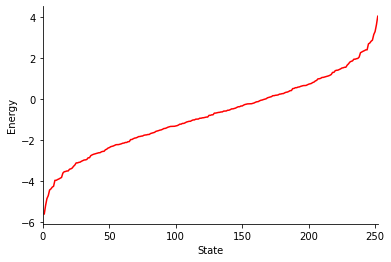

In [3268]:
fig, axes = plt.subplots()
axes.plot(np.linspace(1,size(k,m),size(k,m)),sorted_energies, 'red')
axes.spines['top'].set_color('none')
axes.spines['right'].set_color('none')
axes.set_xlabel('State')
axes.set_ylabel('Energy')
axes.set_xlim((0,252))
fig.savefig("h_0")

In [3590]:
sigma_w = 0.001
init_state = int(size(k,m)/2)

In [3591]:
H_0 = np.zeros((size(k,m),size(k,m))) #generating a zero matrix which has dimensions of the number of permutations of the initial state

for i in range(size(k,m)):
    H_0[i][i] = sorted_energies[i] #filling the diagonals with the energy eigenvalues

w = np.empty((size(k,m),size(k,m))) #generating an empty matrix with the same dimensions as H_0

for i in range(size(k,m)):
    for j in range(size(k,m)):
        w[i][j] = normal(0,sigma_w) #loops through all possible elements of w and samples a normal distribution, can change variance sigma_w to change strength of interactions

w_T = np.transpose(w) #determines the transpose of the matrix w

W = (w+w_T)/2 #ensuring that the random matrix W is real and symmetric

H = H_0 + W #H is the hamiltonian with interactions due to the random matrix (non-diagonal)

#Diagonalisation of H:

hCUDA = CP.CUDAContext() #obtain CUDA context (only 1 needed)

hCUBLAS = CP.CUBLASContext() 
hCUBLAS.Create() #create CUBLAS context (for basic linear algebra ops)

hCUSolverDense = CP.CUSolverDenseContext()
hCUSolverDense.Create() #create CUSolver Context (for dense matrix ops)

#allocating memory on the CPU to fit a matrix of size size X size
hHostMatrix = CP.CUDAHostMemory()
hHostMatrix.Allocate2D(CP.CUDANumericSizeRD, size(k,m), size(k,m), CP.CUDAHostMemoryAllocFlags.PINNED)

hHostVector = CP.CUDAHostMemory()
hHostVector.Allocate1D(CP.CUDANumericSizeRD, size(k,m), CP.CUDAHostMemoryAllocFlags.PINNED)

for i in range(size(k,m)):
    for j in range(size(k,m)):
        hHostMatrix.WriteRD(CP.CUDAMemoryPosition(i,j,0), H[i][j]) #initialising values

#allocating memory on the GPU to fit a matrix of size size X size
hDeviceMatrixA = CP.CUDADeviceMemory()
hDeviceMatrixA.Allocate2D(CP.CUDANumericSizeRD, size(k,m), size(k,m))

hDeviceVectorX = CP.CUDADeviceMemory()
hDeviceVectorX.Allocate1D(CP.CUDANumericSizeRD, size(k,m))

hCUBLAS.SetMatrix(hDeviceMatrixA, CP.CUDAMemoryPosition(), hHostMatrix, CP.CUDAMemoryPosition(), CP.CUDAMemoryRegion(size(k,m),size(k,m),1)) #copy memory from CPU to GPU
hCUDA.WaitForCurrentDevice() #sync

#build and setup of solver
hEigenSolver = CP.CUSolverDenseEigenValue(hCUSolverDense)
hEigenSolver.SetMatrixA(hDeviceMatrixA)
hEigenSolver.SetMatrixFillModeA(CP.CUBLASContextFillMode.UPPER)
hEigenSolver.SetVectorX(hDeviceVectorX)
hEigenSolver.SetAlgorithm(CP.CUSolverDenseEigenValueAlgorithm.QR) #householder reduction method???
hEigenSolver.ComputeEigenVectors(True)

hEigenSolver.PrepareRD() #allocates workspace memory

#solve and sync
hEigenSolver.SolveRD()
hCUDA.WaitForCurrentDevice()
hEigenSolver.UpdateStateAfterSync()

#copy memory from GPU to CPU
hCUBLAS.GetMatrix(hHostMatrix, CP.CUDAMemoryPosition(), hDeviceMatrixA, CP.CUDAMemoryPosition(), CP.CUDAMemoryRegion(size(k,m), size(k,m), 1))
hCUDA.WaitForCurrentDevice()

hCUBLAS.GetVector(hHostVector, CP.CUDAMemoryPosition(), hDeviceVectorX, CP.CUDAMemoryPosition(), CP.CUDAMemoryRegion(size(k,m), 1, 1))
hCUDA.WaitForCurrentDevice()

hPos = CP.CUDAMemoryPosition()

D = np.zeros((size(k,m), size(k,m))) #initialising matrix to be used to store the eigenvalues as diagonal elements
P = np.zeros((size(k,m), size(k,m))) #initialising basis change matrix (H=PDP^-1)

for hPos.iX in range(size(k,m)):
    D[hPos.iX][hPos.iX] = hHostVector.ReadRD(hPos) #sets the diagonal elements of the matrix to the eigenvalues computed using the above algorithm

#need to prepare P matrix using the eigenvectors given by the above algorithm
for hPos.iY in range(size(k,m)):
    for hPos.iX in range(size(k,m)):
        P[hPos.iY][hPos.iX] = hHostMatrix.ReadRD(hPos)

P_T = np.transpose(P)

#free memory and destroy contexts
hDeviceVectorX.Free()
hDeviceMatrixA.Free()
hHostVector.Free()
hHostMatrix.Free()

hCUSolverDense.Destroy()
hCUBLAS.Destroy()

In [3490]:
state = sorted_states[init_state]

In [3491]:
state

(0, 1, 0, 1, 0, 1, 1, 1, 0, 0)

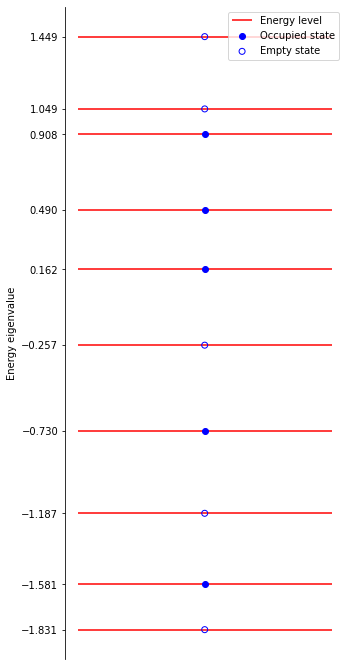

In [3492]:
plot_init_state(random_energies_2, state)

In [3486]:
runs = 1000

In [3543]:
sigma = [1]

In [3544]:
mean_1 = []
mean_2 = []
mean_3 = []
mean_4 = []
mean_5 = []
mean_6 = []

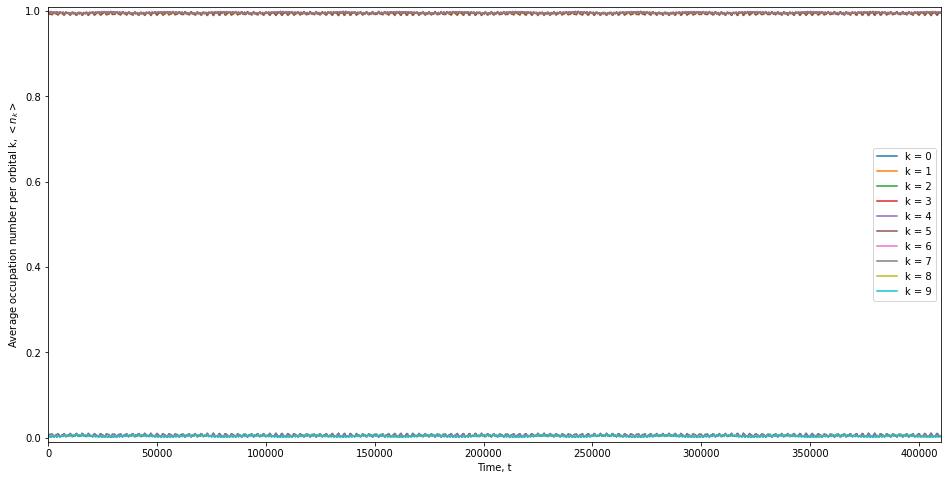

In [3592]:
s = np.zeros(size(k,m))

s[init_state] = 1

t = np.empty(runs)
k0 = np.empty(runs)
k1 = np.empty(runs)
k2 = np.empty(runs)
k3 = np.empty(runs)
k4 = np.empty(runs)
k5 = np.empty(runs)
k6 = np.empty(runs)
k7 = np.empty(runs)
k8 = np.empty(runs)
k9 = np.empty(runs)
dt = time_step(init_state, sigma_w)

for i in range(runs):
    t[i] = dt*i
    
    if i==0:
        k0[i] = occupation_number(s, 0)
        k1[i] = occupation_number(s, 1)
        k2[i] = occupation_number(s, 2)
        k3[i] = occupation_number(s, 3)
        k4[i] = occupation_number(s, 4)
        k5[i] = occupation_number(s, 5)
        k6[i] = occupation_number(s, 6)
        k7[i] = occupation_number(s, 7)
        k8[i] = occupation_number(s, 8)
        k9[i] = occupation_number(s, 9)
    else:
        s = next_state(V_t(dt), s)
        k0[i] = occupation_number(s, 0)
        k1[i] = occupation_number(s, 1)
        k2[i] = occupation_number(s, 2)
        k3[i] = occupation_number(s, 3)
        k4[i] = occupation_number(s, 4)
        k5[i] = occupation_number(s, 5)
        k6[i] = occupation_number(s, 6)
        k7[i] = occupation_number(s, 7)
        k8[i] = occupation_number(s, 8)
        k9[i] = occupation_number(s, 9)

fig, axes = plt.subplots(figsize=((16,8)))
axes.plot(t,k0, label='k = 0')
axes.plot(t,k1, label='k = 1')
axes.plot(t,k2, label='k = 2')
axes.plot(t,k3, label='k = 3')
axes.plot(t,k4, label='k = 4')
axes.plot(t,k5, label='k = 5')
axes.plot(t,k6, label='k = 6')
axes.plot(t,k7, label='k = 7')
axes.plot(t,k8, label='k = 8')
axes.plot(t,k9, label='k = 9')
axes.set_ylim((-0.01,1.01))
axes.set_xlim((0,t[-1]))
axes.set_xlabel("Time, t")
axes.set_ylabel(r"Average occupation number per orbital k, $<n_{k}>$")
#axes.set_title(f"Evolution of state {init_state} with $\sigma$ = {sigma_w}")
axes.legend()
fig.savefig("sigma_0_001")

In [3554]:
mean_1.append(np.mean(k0))
mean_1.append(np.mean(k1))
mean_1.append(np.mean(k2))
mean_1.append(np.mean(k3))
mean_1.append(np.mean(k4))
mean_1.append(np.mean(k5))
mean_1.append(np.mean(k6))
mean_1.append(np.mean(k7))
mean_1.append(np.mean(k8))
mean_1.append(np.mean(k9))

In [3559]:
mean_2.append(np.mean(k0))
mean_2.append(np.mean(k1))
mean_2.append(np.mean(k2))
mean_2.append(np.mean(k3))
mean_2.append(np.mean(k4))
mean_2.append(np.mean(k5))
mean_2.append(np.mean(k6))
mean_2.append(np.mean(k7))
mean_2.append(np.mean(k8))
mean_2.append(np.mean(k9))

In [3576]:
mean_3.append(np.mean(k0))
mean_3.append(np.mean(k1))
mean_3.append(np.mean(k2))
mean_3.append(np.mean(k3))
mean_3.append(np.mean(k4))
mean_3.append(np.mean(k5))
mean_3.append(np.mean(k6))
mean_3.append(np.mean(k7))
mean_3.append(np.mean(k8))
mean_3.append(np.mean(k9))

In [3583]:
mean_4.append(np.mean(k0))
mean_4.append(np.mean(k1))
mean_4.append(np.mean(k2))
mean_4.append(np.mean(k3))
mean_4.append(np.mean(k4))
mean_4.append(np.mean(k5))
mean_4.append(np.mean(k6))
mean_4.append(np.mean(k7))
mean_4.append(np.mean(k8))
mean_4.append(np.mean(k9))

In [3588]:
mean_5.append(np.mean(k0))
mean_5.append(np.mean(k1))
mean_5.append(np.mean(k2))
mean_5.append(np.mean(k3))
mean_5.append(np.mean(k4))
mean_5.append(np.mean(k5))
mean_5.append(np.mean(k6))
mean_5.append(np.mean(k7))
mean_5.append(np.mean(k8))
mean_5.append(np.mean(k9))

In [3593]:
mean_6.append(np.mean(k0))
mean_6.append(np.mean(k1))
mean_6.append(np.mean(k2))
mean_6.append(np.mean(k3))
mean_6.append(np.mean(k4))
mean_6.append(np.mean(k5))
mean_6.append(np.mean(k6))
mean_6.append(np.mean(k7))
mean_6.append(np.mean(k8))
mean_6.append(np.mean(k9))

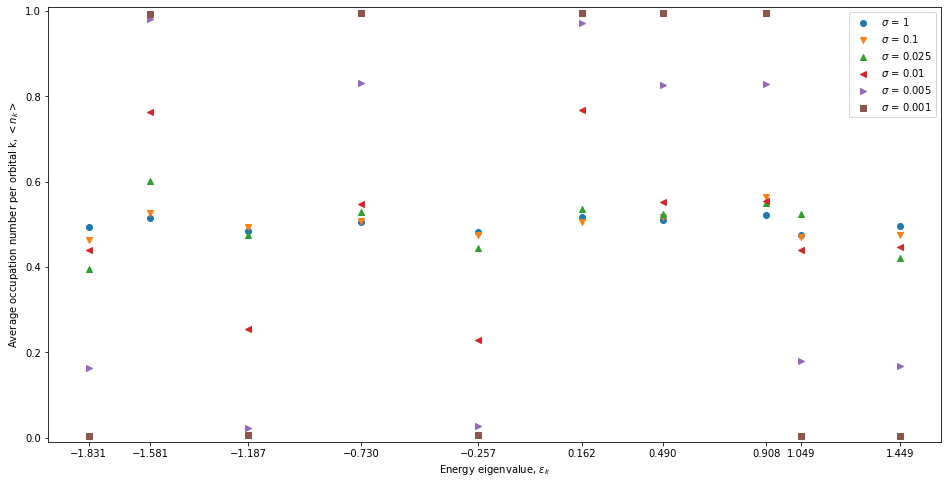

In [3604]:
fig, axes = plt.subplots(figsize=((16,8)))
axes.scatter(random_energies_2,mean_1, label=r'$\sigma$ = 1', marker='o')
axes.scatter(random_energies_2,mean_2, label=r'$\sigma$ = 0.1', marker='v')
axes.scatter(random_energies_2,mean_3, label=r'$\sigma$ = 0.025', marker='^')
axes.scatter(random_energies_2,mean_4, label=r'$\sigma$ = 0.01', marker='<')
axes.scatter(random_energies_2,mean_5, label=r'$\sigma$ = 0.005', marker='>')
axes.scatter(random_energies_2,mean_6, label=r'$\sigma$ = 0.001', marker='s')
axes.set_ylim((-0.01,1.01))
axes.set_xlabel(r"Energy eigenvalue, $\epsilon_{k}$")
axes.set_ylabel(r"Average occupation number per orbital k, $<n_{k}>$")
axes.set_xticks(random_energies_2)
axes.legend()
fig.savefig("occupation_vs_energy") 